# Download the dataset

In [1]:
from tqdm import tqdm
import urllib

url = "https://storage.googleapis.com/linnarsson-lab-www-blobs/blobs/cortex/expression_mRNA_17-Aug-2014.txt"
r = urllib.urlopen(url)
total_size = int(r.headers['content-length'])/1000; 

def readIter(f, blocksize=1000):
    """Given a file 'f', returns an iterator that returns bytes of
    size 'blocksize' from the file, using read()."""
    while True:
        data = f.read(blocksize)
        if not data: break
        yield data
        
with open('expression.bin', 'wb') as f:
    for data in tqdm(readIter(r), total=total_size, unit='KB', unit_scale=False):
        f.write(data)

121130KB [00:01, 104852.86KB/s]                            


# Import the scVI model

In [2]:
%load_ext autoreload
%autoreload 2
import scVI
import tensorflow as tf
from benchmarking import *
from helper import *

In [3]:
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Loading and filtering data

In [36]:
X = pd.read_csv("expression.bin", sep="\t", low_memory=False).T
clusters = np.array(X[7], dtype=str)[2:]
cell_types, labels = np.unique(clusters, return_inverse=True)
gene_names = np.array(X.iloc[0], dtype=str)[10:]
X = X.loc[:, 10:]
X = X.drop(X.index[0])
expression_data = np.array(X, dtype=np.int)[1:]

# keep the most variable genes according to the Biscuit ICML paper
selected = np.std(expression_data, axis=0).argsort()[-558:][::-1]
expression_data = expression_data[:, selected]
gene_names = gene_names[selected].astype(str)

#train test split for log-likelihood scores
expression_train, expression_test, c_train, c_test = train_test_split(expression_data, labels, random_state=0)

In [37]:
# visualizing the cell-types
cell_types

array(['astrocytes_ependymal', 'endothelial-mural', 'interneurons',
       'microglia', 'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS'],
      dtype='|S64')

# Getting prior for scaling parameters

In [5]:
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

# Loading scVI on memory

In [7]:
batch_size = 128
learning_rate = 0.001
epsilon = 0.01
latent_dimension = 10

In [8]:
tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

# getting priors
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

# loading data
model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var)

#starting computing session
sess = tf.Session()

Running scVI on 558 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


In [9]:
# start a new graph and fit the training set
# this takes less than a minute on a Tesla K80
sess.run(tf.global_variables_initializer())
result = train_model(model, (expression_train, expression_test), sess, 250)

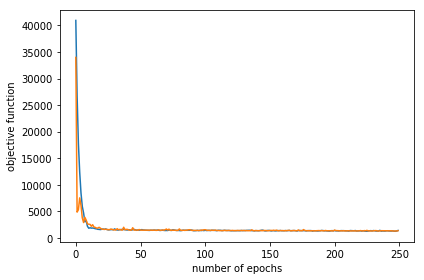

In [10]:
plot_training_info(result)

# Clustering

We can here sample fron the latent space, you can verify that the clustering metrics are robust with respect to different samples from the variational posterior

In [14]:
dic_full = {expression: expression_train, training_phase:False}
latent = sess.run(model.z, feed_dict=dic_full)
clustering_score = cluster_scores(latent, 7, c_train)
print "Silhouette", clustering_score[0], "\nAdjusted Rand Index", clustering_score[1], \
        "\nNormalized Mutual Information", clustering_score[2]

Silhouette 0.228034 
Adjusted Rand Index 0.797367379545 
Normalized Mutual Information 0.821613560628


# Visualization

Our latent space is low-dimensional and therefore tSNE friendly !

In [15]:
def show_tSNE(latent, labels):
    tsne = TSNE().fit_transform(latent)
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, \
                                   cmap=plt.get_cmap("tab10", 7), edgecolors='none')
    plt.axis("off")

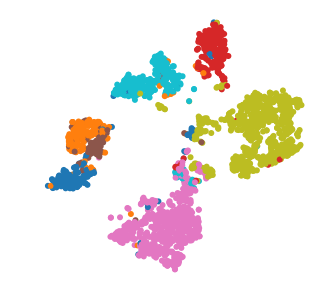

In [16]:
show_tSNE(latent, c_train)

# Imputation

In the original submission, we recomplete scVI's inference on corrupted data and we evaluate how well different algorithms can recover the original information. In this notebook, we instead show how to sample the parameters of the generative model

In [60]:
dic_full = {expression: expression_train, training_phase:False, kl_scalar:1.} 
scale_ = sess.run(model.px_scale,  feed_dict=dic_full)

+ px_scale: normalized expression level inside scVI (rho param in the paper, used for DE)
+ px_rate: mean of the negative binomial (used for imputation)
+ px_r: log of the dispersion parameter for every gene (used for posterior analysis)
+ px_dropout: logit of the zero inflation mixture weight

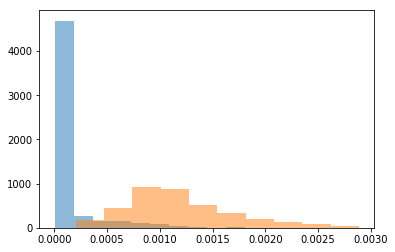

In [107]:
# we can visualize for a gene known to be DE for oligodendrocytes (#4) VS pyramidal CA1 (#5)
gene_index = np.where(gene_names == "Thy1")[0]
plt.hist(scale_[c_train == 4, gene_index], alpha=0.5, normed=True)
plt.hist(scale_[c_train == 5, gene_index], alpha=0.5, normed=True)
plt.show()

# Differential expression

In [108]:
# Say we analyze oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)

# sample 100 cells from each clusters and for each of them, get 200 draws from the posterior
# the more cells, the better. There is a tradeoff (M_z cannot be 200 if A is 10k) but overall this works out well
A, B, M_z = 200, 400, 100
set_a = np.where(c_train == couple_celltypes[0])[0]
set_b = np.where(c_train == couple_celltypes[1])[0]

In [109]:
def sample_posterior(model, X, M_z):
    # shape and simulation
    results = {}
    ind = np.arange(X.shape[0])

    # repeat the data for sampling
    X_m = np.repeat(X, M_z, axis=0)
    gamma_m = np.repeat(r, M_z, axis=0)
    ind = np.repeat(ind, M_z, axis=0)

    #NN part
    dic_x = {expression: X_m, training_phase:False, kl_scalar:1.} 
    z_m, l_m = sess.run((model.z, model.library), feed_dict=dic_x)
    dic_z = {model.z: z_m, model.library:l_m, training_phase:False, kl_scalar:1.}
    rate = sess.run((model.px_scale), feed_dict=dic_z)
    results["sample_rate"] = rate
    results["index"] = ind
    return results

In [110]:
def get_sampling(model, subset_a, subset_b, M_z):
    #get q(z| xa) and q(z| xb) and sample M times from it, then output gamma parametrizations
    res_a = sample_posterior(model, expression_train[subset_a], M_z)
    res_b = sample_posterior(model, expression_train[subset_b], M_z)
    return res_a, res_b

In [111]:
def get_statistics(res_a, res_b, M_p=10000, permutation=False):
    """
    Output average over statistics in a symmetric way (a against b)
    forget the sets if permutation is True
    """
    
    #agregate dataset
    samples = np.vstack((res_a["sample_rate"], res_b["sample_rate"]))
    
    # prepare the pairs for sampling
    list_1 = list(np.arange(res_a["sample_rate"].shape[0]))
    list_2 = list(res_a["sample_rate"].shape[0] + np.arange(res_b["sample_rate"].shape[0]))
    if not permutation:
        #case1: no permutation, sample from A and then from B
        u, v = np.random.choice(list_1, size=M_p), np.random.choice(list_2, size=M_p)
    else:
        #case2: permutation, sample from A+B twice
        u, v = (np.random.choice(list_1+list_2, size=M_p), \
                    np.random.choice(list_1+list_2, size=M_p))
    
    # then constitutes the pairs
    first_set = samples[u]
    second_set = samples[v]
    
    res = np.mean(first_set >= second_set, 0)
    res = np.log(res) - np.log(1-res)
    return res

In [112]:
subset_a = np.random.choice(set_a, A)
subset_b = np.random.choice(set_b, B)
res_a, res_b = get_sampling(model, subset_a, subset_b, M_z)
st = get_statistics(res_a, res_b, M_p=100000)

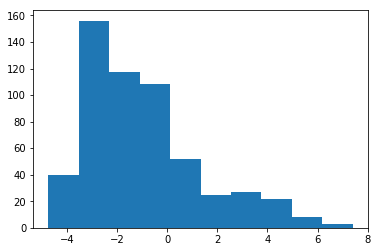

In [113]:
# Vizualize the Bayes Factor, high absolute values imply statistical significance
# Throughout the paper, we discuss 3 as a strong threshold
plt.hist(st)
plt.show()

In [114]:
st[np.where(gene_names == "Thy1")[0]][0], st[np.where(gene_names == "Mbp")[0]][0]

(-3.433326763823402, 3.496569381446716)

# STEP 2: We add fake batch names and provide code to remove batch effects

We hallucinate some batch effects in the data in order to show the user how to run scVI on batch data. 

In [123]:
# usually the batch info would have been split with the sklearn train_test_split function
b_train = np.zeros_like(c_train)
b_train[::2] = 1
b_test = np.zeros_like(c_test)
b_test[::2] = 1

First step towards removing batch effects, we adjust the library size prior to be batch-specific in order to model overall sample / library quality.

In [119]:
# compute prior for library size for each batch
l_mean, l_var = [], []
log_library_size = np.log(np.sum(expression_train, axis=1))
for i in np.unique(b_train):
    l_mean.append([np.mean(log_library_size[b_train == i])])
    l_var.append([np.var(log_library_size[b_train == i])])
    
zip(*(l_mean, l_var))

[([8.4468653145212311], [0.44424142093526214]),
 ([8.4405417362460469], [0.43061329446712038])]

Nothing interesting here since everything is random, but this is really useful in practice !

In [121]:
tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
batch_ind = tf.placeholder(tf.int32, [None], name='b_ind')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')
mmd_scalar = tf.placeholder(tf.float32, [], name='l')

# The dispersion parameter in scVI can be gene specific or gene-batch specific. Usually, gene is enough.
model = scVI.scVIModel(expression=expression, batch_ind=batch_ind, num_batches=2, kl_scale=kl_scalar, \
                         apply_mmd=False, phase=training_phase, mmd_scale=mmd_scalar, optimize_algo=optimizer,  \
                          library_size_mean=tf.constant(l_mean), library_size_var=tf.constant(l_var), \
                           dispersion="gene", n_latent=latent_dimension, n_layers=1)
# Session creation
sess = tf.Session()

Running scVI on 558 genes
Got 2batches in the data
Will not apply a MMD penalty
Will work on mode list for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


In [124]:
sess.run(tf.global_variables_initializer())
result = train_model(model, (expression_train, expression_test), sess, 120, batch=(b_train, b_test))

we extend the differential expression code to choose a reference batch. Another option as chosen in the paper is to take the posterior by mixing over all possible references. That has a linear complexity in the number of batches and is therefore acceptable.

In [125]:
def sample_posterior(model, X, b, M_z, reference_batch=0):
    # shape and simulation
    results = {}
    ind = np.arange(X.shape[0])

    # repeat the data for sampling
    X_m = np.repeat(X, M_z, axis=0)
    batch_m = np.repeat(b, M_z, axis=0)
    ind = np.repeat(ind, M_z, axis=0)
    
    # repeat the same batch for regenerating
    
    batch_rm = reference_batch * np.ones(b.shape[0])
    batch_rm = np.repeat(batch_rm, M_z, axis=0)
    
    #NN part
    dic_x = {expression: X_m, batch_ind:batch_m, training_phase:False, kl_scalar:1., mmd_scalar: 100} 
    z_m, l_m = sess.run((model.z, model.library), feed_dict=dic_x)
    dic_z = {model.z: z_m, model.library:l_m, batch_ind:batch_rm, training_phase:False, kl_scalar:1.}
    rate = sess.run((model.px_scale), feed_dict=dic_x)
    results["sample_rate"] = rate
    results["index"] = ind
    return results

In [126]:
def get_sampling(model, subset_a, subset_b, M_z, reference_batch=0):
    #get q(z| xa) and q(z| xb) and sample M times from it, then output gamma parametrizations
    x_a = expression_train[subset_a, :]
    x_b = expression_train[subset_b, :]
    res_a = sample_posterior(model, x_a, b_train[subset_a], M_z, reference_batch=reference_batch)
    res_b = sample_posterior(model, x_b, b_train[subset_b], M_z, reference_batch=reference_batch)
    return res_a, res_b

In [127]:
def get_statistics(res_a, res_b, M_p=10000, permutation=False):
    """
    Output average over statistics in a symmetric way (a against b)
    forget the sets if permutation is True
    """
    
    #agregate dataset
    samples = np.vstack((res_a["sample_rate"], res_b["sample_rate"]))
    
    # prepare the pairs for sampling
    list_1 = list(np.arange(res_a["sample_rate"].shape[0]))
    list_2 = list(res_a["sample_rate"].shape[0] + np.arange(res_b["sample_rate"].shape[0]))
    if not permutation:
        #case1: no permutation, sample from A and then from B
        u, v = np.random.choice(list_1, size=M_p), np.random.choice(list_2, size=M_p)
    else:
        #case2: permutation, sample from A+B twice
        u, v = (np.random.choice(list_1+list_2, size=M_p), \
                    np.random.choice(list_1+list_2, size=M_p))
    
    # then constitutes the pairs
    first_set = samples[u]
    second_set = samples[v]
    
    res = np.mean(first_set >= second_set, 0)
    res = np.log(res) - np.log(1-res)
    return res

### That's all for today, do no hesitate to notify me if you believe something is missing on this notebook !